<a href="https://colab.research.google.com/github/ikanx101/G-Colab/blob/main/Deep_Learning_Forum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _Deep Learning_ Forum
## _Data Science_ @Nutrifood
### By: ikanx101.com

Oke, kali ini kita akan _unboxing_ metode _deep learning_ menggunakan _tools_ `TensorFlow` milik Google.

`TensorFlow` tidak perlu di-_install_ ke laptop / komputer _local_. Kita bisa menggunakannya dengan mengakses Google Colab.

Ada hal yang perlu dilakukan sebelum kita _run_ semua kode ini, yakni meng-_install_ _libraries_ berikut ini:

1. `caret`: diperlukan untuk _pre-processing_ ala _machine learning_.
1. `keras`: untuk tambahan `tensorflow`.

In [ ]:
# proses instalasi libraries
  # install.packages("caret")
  # install.packages("keras")

In [ ]:
# dimulai dari hati yang bersih
rm(list=ls())

# memanggil semua libraries yang diperlukan
library(dplyr)
library(tidyr)
library(caret)
library(keras)
library(tensorflow)

# kita akan ambil datanya
urls = "https://raw.githubusercontent.com/ikanx101/Live-Session-Nutrifood-R/master/Kaggle%20Data/WC%20Qatar%202022/rekapan%20all/data%20WC.csv"
df   = read.csv(urls) |> select(-X,-negara) |>
                         mutate(status = ifelse(status == "win",1,0))

# kita lihat terlebih dahulu struktur datanya seperti apa
str(df)

'data.frame':	118 obs. of  111 variables:
 $ distance_high_speed_running                       : num  13493 16370 12636 11488 13813 ...
 $ total_distance                                    : num  111602 120992 105127 104910 112211 ...
 $ distance_walking                                  : num  42308 39044 40547 42593 44267 ...
 $ distance_jogging                                  : num  47509 56661 44437 42940 44301 ...
 $ distance_high_speed_sprinting                     : num  2009 1948 1840 2518 2951 ...
 $ distance_low_speed_sprinting                      : num  6283 6981 5656 5371 6867 ...
 $ linebreaks_attempted_attacking_line_completed     : int  63 48 30 48 29 22 75 27 50 50 ...
 $ linebreaks_attempted_completed                    : int  135 92 66 100 68 127 172 81 123 118 ...
 $ linebreaks_attempted_defensive_line               : int  16 12 13 10 15 39 21 17 23 13 ...
 $ final_third_entries_reception_central_channel     : int  11 2 1 2 3 5 4 2 8 5 ...
 $ possession             

In [ ]:
# sekarang kita akan buat input utk tensorflow
# jadi sebelum dipisah kita akan pre-process dulu

# kita save dulu variabel targetnya
target = df$status

# lalu kita hilangkan dari data awalnya
df     = df |> select(-status)

In [ ]:
preProcess_range_model = preProcess(df, method='scale')
df                     = predict(preProcess_range_model, newdata = df) #variabel targetnya hilang di sini
df$status              = target

Warning message in preProcess.default(df, method = "scale"):
“These variables have zero variances: goals_conceded_from_attempt_at_goal_against”


In [ ]:
# kita lihat apakah data yang ada balance atau tidak
table(df$status)

# ternyata tidak balance
# tidak mengapa, kita coba akan pisah menjadi train dan tes
# pemisahannya adalah 37 utk train dan sisanya tes

# pemisahan tahap 1
df_0 = df |> filter(status == 0)
df_1 = df |> filter(status == 1)

# kita akan acak id nya
# jangan lupa set seed dulu
set.seed(123)
id_0 = sample(nrow(df_0),28,replace = F)
id_1 = sample(nrow(df_1),28,replace = F)

# data train
train_0 = df_0[id_0,]
train_1 = df_1[id_1,]
train   = rbind(train_1,train_0)

# kita cek kembali balance dari train
table(train$status)

# sekarang kita akan buat test data
test_0 = df_0[-id_0,]
test_1 = df_1[-id_1,]
test   = rbind(test_0,test_1)

# kita cek kembali balance dari test
table(test$status)



 0  1 
73 45 


 0  1 
28 28 


 0  1 
45 17 

In [ ]:
# kita ubah targetnya ke bentuk matriks
train_label_raw   = train$status
train_label_clean = to_categorical(train_label_raw)
train_matrix      = as.matrix(train[-ncol(train)])

# test
test_label_raw    = test$status
test_label_clean  = to_categorical(test_label_raw)
test_matrix       = as.matrix(test[-ncol(train)])

In [ ]:
model = keras_model_sequential()
model %>%
  layer_dense(units       = 100,activation = 'sigmoid',
              input_shape = c(ncol(train_matrix))) %>%
  layer_dense(units       = 86, activation = 'relu') %>%
  layer_dense(units       = 21, activation = 'sigmoid') %>%
  layer_dense(units       = 12, activation = 'softmax') %>%
  layer_dense(units       = 2, activation = 'relu')

summary(model)

model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

Model: "sequential_13"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_77 (Dense)                   (None, 100)                     11100       
 dense_76 (Dense)                   (None, 86)                      8686        
 dense_75 (Dense)                   (None, 21)                      1827        
 dense_74 (Dense)                   (None, 12)                      264         
 dense_73 (Dense)                   (None, 2)                       26          
Total params: 21,903
Trainable params: 21,903
Non-trainable params: 0
________________________________________________________________________________


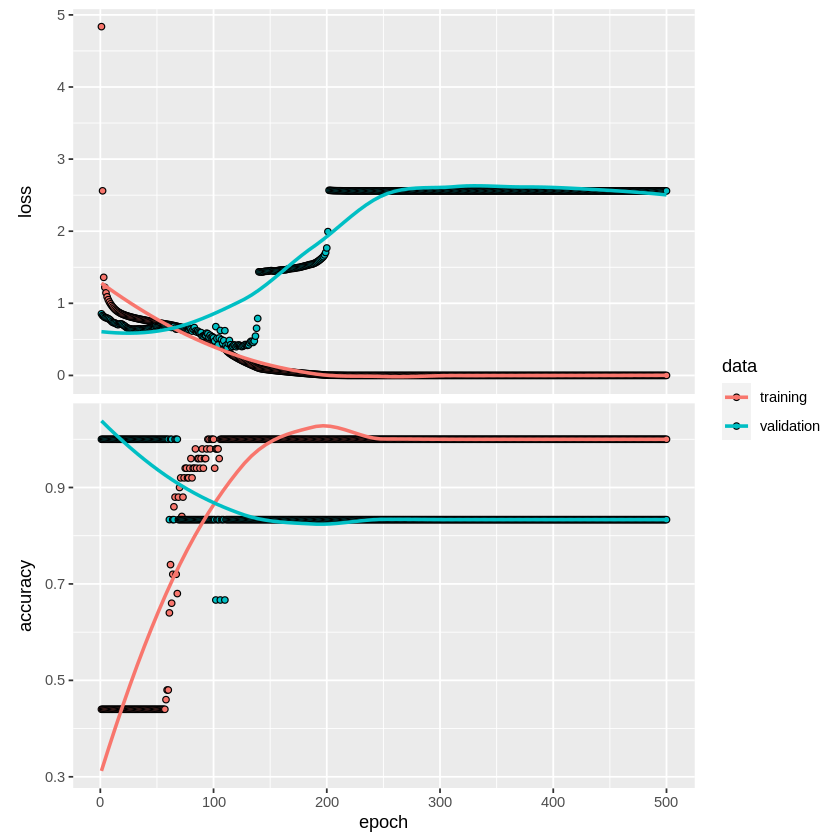

In [ ]:
fitModel =
  model %>%
  fit(train_matrix,
      train_label_clean,
      epochs = 500,
      batch_size = 15,
      validation_split = 0.1)

plot(fitModel)

In [ ]:
# evaluasi dengan train
model %>% evaluate(train_matrix, train_label_clean, verbose = 0)

# evaluasi dengan test
model %>% evaluate(test_matrix, test_label_clean, verbose = 0)

loss  accuracy 
0.2741338 0.9821429

loss  accuracy 
1.1969688 0.8709677

In [ ]:
pred_train = predict(model, train_matrix) %>% k_argmax() %>% as.vector()
table(pred_train,train_label_raw)
mean(train_label_raw == pred_train)

# Pakai test
pred_test = predict(model, test_matrix) %>% k_argmax() %>% as.vector()
table(pred_test,test_label_raw)
mean(test_label_raw == pred_test)

          train_label_raw
pred_train  0  1
         0 27  0
         1  1 28

[1] 0.9821429

         test_label_raw
pred_test  0  1
        0 38  1
        1  7 16

[1] 0.8709677